In [4]:
from qiskit import *
q = QuantumRegister(5,"q")
c = ClassicalRegister(5,"c")
circuit = QuantumCircuit(q,c)


circuit.h(q[0])
circuit.h(q[1])
circuit.h(q[2])
circuit.h(q[3])
circuit.x(q[4])
circuit.u1(-0.0706860, q[0])
circuit.u1(-0.1335178, q[1])
circuit.u1(-0.2356196, q[2])
circuit.u1(-0.3141594, q[3])
circuit.cx(q[4],q[0])
circuit.u1(0.3848452, q[0])
circuit.cx(q[4],q[1])
circuit.h(q[0])
circuit.cx(q[4],q[2])
circuit.u1(1.0210178, q[2])
circuit.h(q[1])
circuit.cx(q[4],q[3])
circuit.u1(1.8849556, q[3])
circuit.h(q[2])
circuit.h(q[3])
circuit.measure(q[3], c[3])
circuit.measure(q[2], c[2])
circuit.measure(q[1], c[1])
circuit.measure(q[0], c[0])
circuit.measure(q[4], c[4])

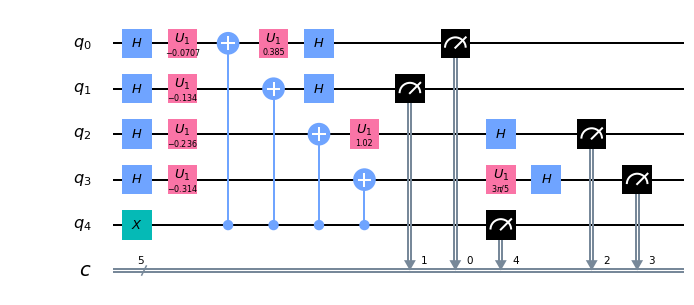

In [5]:
circuit.draw(output='mpl')

In [6]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator).result()

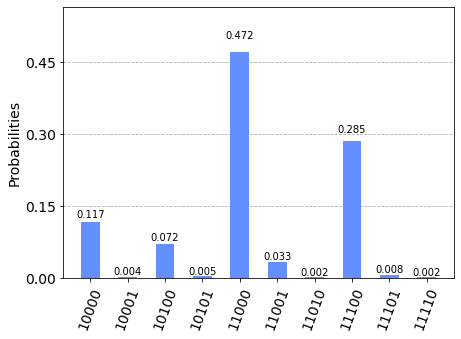

In [7]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

In [9]:
IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_essex')
job = execute(circuit,backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [12]:
result = job.result()

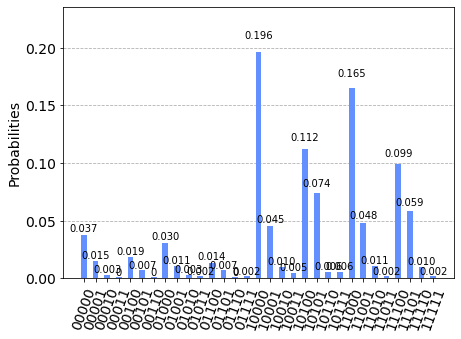

In [13]:
plot_histogram(result.get_counts(circuit))